# Portland Trail Blazers - Extended Feature Selection
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Dec 20, 2021

## Hypothesis
Two very important components of a machine learning model are feature selection and feature engineering. Our idea is that adding some more features to the StellarAlgo retention model could improve performance of the model. This notebook will test the standard StellarAlgo retention model features.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [33]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [34]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [35]:
lkupclientid = 5 # blazers
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrTrailBlazers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(27487, 56)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27487 entries, 0 to 27486
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              27487 non-null  int64  
 1   dimCustomerMasterId       27487 non-null  int64  
 2   customerNumber            27485 non-null  object 
 3   year                      27487 non-null  int64  
 4   productGrouping           27487 non-null  object 
 5   totalSpent                27487 non-null  float64
 6   recentDate                27487 non-null  object 
 7   attendancePercent         27487 non-null  float64
 8   renewedBeforeDays         27487 non-null  int64  
 9   isBuyer                   27487 non-null  object 
 10  source_tenure             27487 non-null  int64  
 11  tenure                    27487 non-null  int64  
 12  distToVenue               0 non-null      object 
 13  totalGames                27487 non-null  int64  
 14  recenc

### We should specify the features used in our model:

In [37]:
# choose the features for the stellar base retention model
features = [
    "annualHHIncome",
    "attendancePercent",
    "cancel_records",
    "childrenPresentInHH", 
    "clickToOpenRatio", 
    "clickToSendRatio",
    "dimCustomerMasterId",
    "distToVenue",
    "education",
    "fill_out_form",
    "forward_records",
    "gender",
    "isNextYear_Buyer",
    "lengthOfResidenceInYrs",
    "maritalStatus",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "openToSendRatio",
    "posting_records",
    "productGrouping",
    "recency",
    "renewedBeforeDays",
    "resale_atp",
    "resale_records",
    "source_tenure",
    "tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (18607, 29)
Unseen Data For Predictions: (3284, 29)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [38]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "annualHHIncome",
        "attendancePercent",
        "cancel_records",
        "childrenPresentInHH", 
        "clickToOpenRatio", 
        "clickToSendRatio",
        "distToVenue",
        "fill_out_form",
        "forward_records",
        "lengthOfResidenceInYrs",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "openToSendRatio",
        "posting_records",
        "recency",
        "renewedBeforeDays",
        "resale_atp",
        "resale_records",
        "source_tenure",
        "tenure",
        "totalSpent"
    ]
);

In [39]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7926,0.8591,0.8714,0.8162,0.8429,0.5388,0.5414,0.8500
lr,Logistic Regression,0.7574,0.8138,0.8555,0.7842,0.8182,0.4555,0.4595,0.4450


In [40]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8015,0.8703,0.8842,0.8193,0.8505,0.5566,0.5602
1,0.7895,0.8530,0.8713,0.8126,0.8409,0.5311,0.5339
2,0.7914,0.8606,0.8653,0.8184,0.8412,0.5380,0.5398
3,0.7990,0.8558,0.8812,0.8180,0.8484,0.5513,0.5547
4,0.7920,0.8667,0.8743,0.8138,0.8430,0.5364,0.5394
5,0.7881,0.8515,0.8722,0.8103,0.8401,0.5274,0.5305
6,0.7919,0.8537,0.8712,0.8154,0.8424,0.5373,0.5398
7,0.7717,0.8436,0.8583,0.7989,0.8275,0.4911,0.4939
8,0.8058,0.8760,0.8632,0.8375,0.8502,0.5745,0.5751
9,0.7951,0.8600,0.8733,0.8182,0.8448,0.5441,0.5466


### Let's load in our 2021 season data and get retention scores using the model:

In [48]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(5596, 56)

In [49]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupClientId,dimCustomerMasterId,customerNumber,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,isBuyer,...,isnextyear_buyer,isnextyear_samepkg_buyer,pkgupgrade_status,auto_renewal,credits_after_refund,is_Lockdown,isNextYear_Buyer,Label,Score_0,Score_1
21891,5,298267187,211139709,2021,Half Season,104.00,1970-01-01,0.000000,251,TRUE,...,0,0,0,0,0.0,1,0,0,0.9981,0.0019
21892,5,298495769,201019586,2021,Full Season,7482.00,2021-11-23,1.090909,119,TRUE,...,0,0,0,0,0.0,1,0,0,0.7215,0.2785
21893,5,299088720,207050629,2021,Quarter Season,1500.00,2021-10-27,1.000000,99,TRUE,...,0,0,0,0,0.0,1,0,0,0.9074,0.0926
21894,5,299091531,921909,2021,Full Season,6501.60,2021-11-23,0.590909,270,TRUE,...,0,0,0,0,0.0,1,0,0,0.5863,0.4137
21895,5,299111838,925839,2021,Full Season,6908.38,2021-11-23,0.818182,265,TRUE,...,0,0,0,0,0.0,1,0,0,0.8039,0.1961


In [53]:
new_predictions["Label"].value_counts()

0    3487
1    2109
Name: Label, dtype: int64

In [48]:
#new_predictions = new_predictions.loc[new_predictions["productGrouping"] == "Full Season"]

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

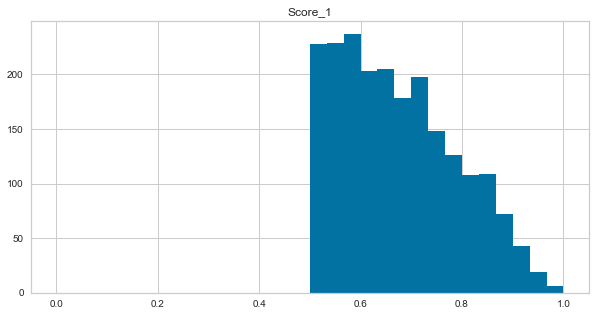

In [51]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

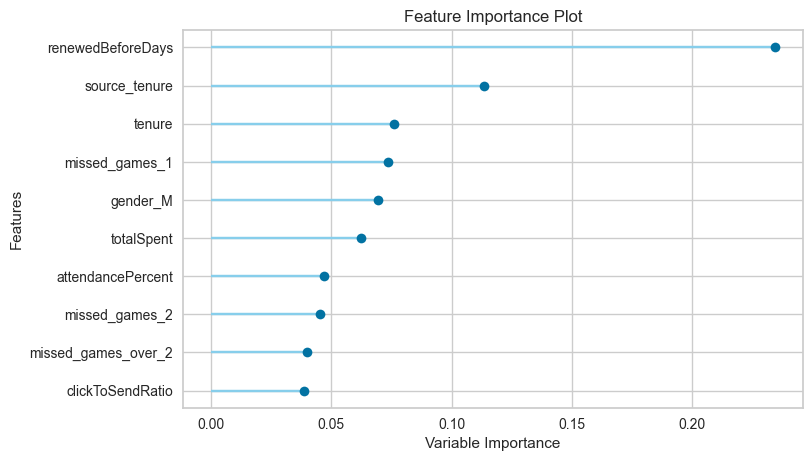

In [52]:
plot_model(best_model, plot='feature')

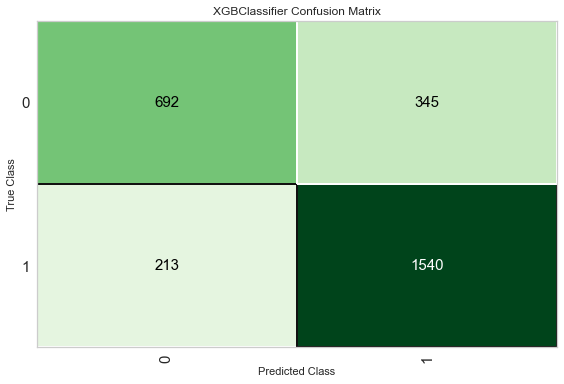

In [30]:
plot_model(best_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?